# Image Classification with CNN and Keras

In [1]:
#import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import tensorflow
from tqdm import tqdm

from tensorflow.keras.models import Model
from tensorflow.keras.layers import  Activation, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

In [3]:
#Mounting our google drive on google colab to access our data files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#unzip the dataset files
!unzip /content/drive/MyDrive/Data/IntelImageClassification_Dataset.zip
!unzip /content/drive/MyDrive/Data/PredictionData.zip


## Step 1: Creating a Sequential model

Will start with creating a sequential model composed of different layers- Conv2D, MaxPooling2D, Activtion, Flatten & Dense. Train it on the training dataset and then check it's performance on our test set.

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense

### Set Up flow For Training & Validation data

In [6]:
# data flow parameters
training_data_dir = '/content/IntelImageClassification_Dataset/seg_train/seg_train'
validation_data_dir = '/content/IntelImageClassification_Dataset/seg_test/seg_test'
batch_size = 32
img_width = 128
img_height = 128
num_channels = 3
num_classes = 6

### Create image generators

* Keras ImageDataGenerator is used to take the inputs of the original data and then transform it on a random basis, returning the output resultant containing solely the newly changed data.

* Rescale is a value by which we will multiply the data before any other processing. Our original images consist in RGB coefficients in the 0-255, but such values would be too high for our model to process (given a typical learning rate), so we target values between 0 and 1 instead by scaling with a 1/255 factor. Using the dot between the division means we'll definitely return float values i.e., with decimal places rather than being returned an integer which will be problematic as then all of our pixels will then be forced to either be 0 or 1


In [16]:
# Generate batches of tensor image data with real-time data augmentation using ImageDataGenerator
training_generator = ImageDataGenerator(rescale = 1./255)
validation_generator = ImageDataGenerator(rescale = 1./255)

# image flows

training_set = training_generator.flow_from_directory(directory = training_data_dir,
                                                      target_size = (img_width, img_height),
                                                      batch_size = batch_size,
                                                      class_mode = 'categorical')
validation_set = validation_generator.flow_from_directory(directory = validation_data_dir,
                                                      target_size = (img_width, img_height),
                                                      batch_size = batch_size,
                                                      class_mode = 'categorical')

Found 2160 images belonging to 6 classes.
Found 208 images belonging to 6 classes.


### Create Network Architecture using Sequential model

* The sequential model allows us to specify a neural network, precisely, sequential: from input to output, passing through a series of neural layers, one after the other.

In [17]:
# network architecture
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (3,3), padding = 'same', input_shape = (img_width, img_height, num_channels)))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(filters = 32, kernel_size = (3,3), padding = 'same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(32))
model.add(Activation('relu'))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

## Step 2: Compile the model

In [18]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

# view network architecture

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 activation_8 (Activation)   (None, 128, 128, 32)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 activation_9 (Activation)   (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                  

## Step 3: Train the Network

In [19]:
# training parameters
num_epochs = 15
model_filename = 'models/imgclf_cnn_v01.h5'


# callbacks
save_best_model = ModelCheckpoint(filepath = model_filename,
                                  monitor = 'val_accuracy',
                                  mode = 'max',
                                  verbose = 1,
                                  save_best_only= True)

# train the network

history = model.fit(x = training_set,
                    validation_data= validation_set,
                    batch_size = batch_size,
                    epochs = num_epochs,
                    callbacks = [save_best_model])

Epoch 1/15
68/68 [==============================] - ETA: 0s - loss: 1.4659 - accuracy: 0.3537
Epoch 1: val_accuracy improved from -inf to 0.48077, saving model to models/imgclf_cnn_v01.h5
68/68 [==============================] - 4s 39ms/step - loss: 1.4659 - accuracy: 0.3537 - val_loss: 1.4341 - val_accuracy: 0.4808
Epoch 2/15
68/68 [==============================] - ETA: 0s - loss: 1.0918 - accuracy: 0.5741
Epoch 2: val_accuracy improved from 0.48077 to 0.56250, saving model to models/imgclf_cnn_v01.h5
68/68 [==============================] - 2s 36ms/step - loss: 1.0918 - accuracy: 0.5741 - val_loss: 1.0505 - val_accuracy: 0.5625
Epoch 3/15
68/68 [==============================] - ETA: 0s - loss: 0.9257 - accuracy: 0.6292
Epoch 3: val_accuracy improved from 0.56250 to 0.57212, saving model to models/imgclf_cnn_v01.h5
68/68 [==============================] - 4s 55ms/step - loss: 0.9257 - accuracy: 0.6292 - val_loss: 1.0657 - val_accuracy: 0.5721
Epoch 4/15
68/68 [======================

## Step 4: Visualize the performance of our model

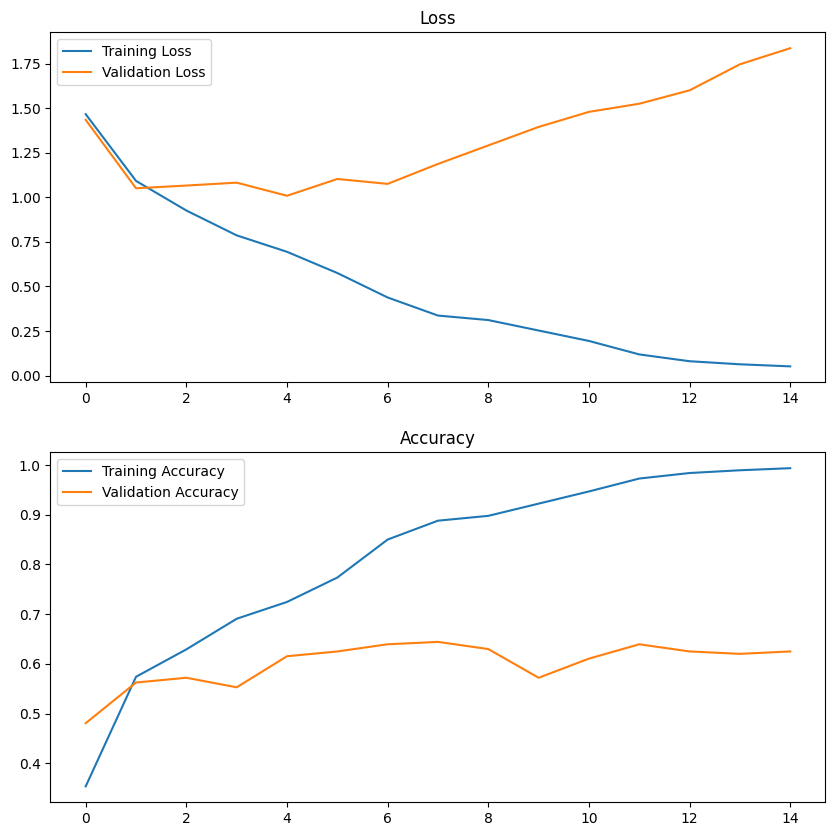

In [20]:
import matplotlib.pyplot as plt

# plot validation results
fig, ax = plt.subplots(2, 1, figsize=(10,10))
ax[0].set_title('Loss')
ax[0].plot(history.epoch, history.history["loss"], label="Training Loss")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation Loss")
ax[1].set_title('Accuracy')
ax[1].plot(history.epoch, history.history["accuracy"], label="Training Accuracy")
ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation Accuracy")
ax[0].legend()
ax[1].legend()
plt.show()

 As evident our model is **overfitting**. Let's add dropout layer and reduce the no. of epochs for training our model and check if generalisation can be achieved.

## Step 5: Create a new Sequential model with a droupout layer

In [92]:
# network architecture with drop out layer added
model_1 = Sequential()

model_1.add(Conv2D(filters = 32, kernel_size = (3,3), padding = 'same', input_shape = (img_width, img_height, num_channels)))
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D())

model_1.add(Conv2D(filters = 32, kernel_size = (3,3), padding = 'same'))
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D())

model_1.add(Flatten())

model_1.add(Dense(32))
model_1.add(Activation('relu'))
model_1.add(Dropout(0.5))

model_1.add(Dense(num_classes))
model_1.add(Activation('softmax'))

### Compile our model

In [93]:
# compile network

model_1.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [94]:
# view network architecture

model_1.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 activation_74 (Activation)  (None, 128, 128, 32)      0         
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 activation_75 (Activation)  (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                

## Step 6:  Train Our new Network with dropout layer

reduce the no. of epochs to 10

In [95]:
# training parameters
num_epochs = 10
model_filename = 'contents/models/imgclf_cnn_v02.h5'


# callbacks
save_best_model = ModelCheckpoint(filepath = model_filename,
                                  monitor = 'val_accuracy',
                                  mode = 'max',
                                  verbose = 1,
                                  save_best_only= True)

# train the network

history = model_1.fit(x = training_set,
                    validation_data= validation_set,
                    batch_size = batch_size,
                    epochs = num_epochs,
                    callbacks = [save_best_model])

Epoch 1/10
67/68 [============================>.] - ETA: 0s - loss: 1.6725 - accuracy: 0.2899
Epoch 1: val_accuracy improved from -inf to 0.40385, saving model to contents/models/imgclf_cnn_v02.h5
68/68 [==============================] - 6s 56ms/step - loss: 1.6680 - accuracy: 0.2931 - val_loss: 1.5244 - val_accuracy: 0.4038
Epoch 2/10
68/68 [==============================] - ETA: 0s - loss: 1.5054 - accuracy: 0.3935
Epoch 2: val_accuracy improved from 0.40385 to 0.46635, saving model to contents/models/imgclf_cnn_v02.h5
68/68 [==============================] - 3s 39ms/step - loss: 1.5054 - accuracy: 0.3935 - val_loss: 1.4601 - val_accuracy: 0.4663
Epoch 3/10
67/68 [============================>.] - ETA: 0s - loss: 1.4465 - accuracy: 0.4258
Epoch 3: val_accuracy improved from 0.46635 to 0.50000, saving model to contents/models/imgclf_cnn_v02.h5
68/68 [==============================] - 3s 38ms/step - loss: 1.4469 - accuracy: 0.4255 - val_loss: 1.4165 - val_accuracy: 0.5000
Epoch 4/10
67

## Step 7: Visualise Training & Validation Performance of the new model

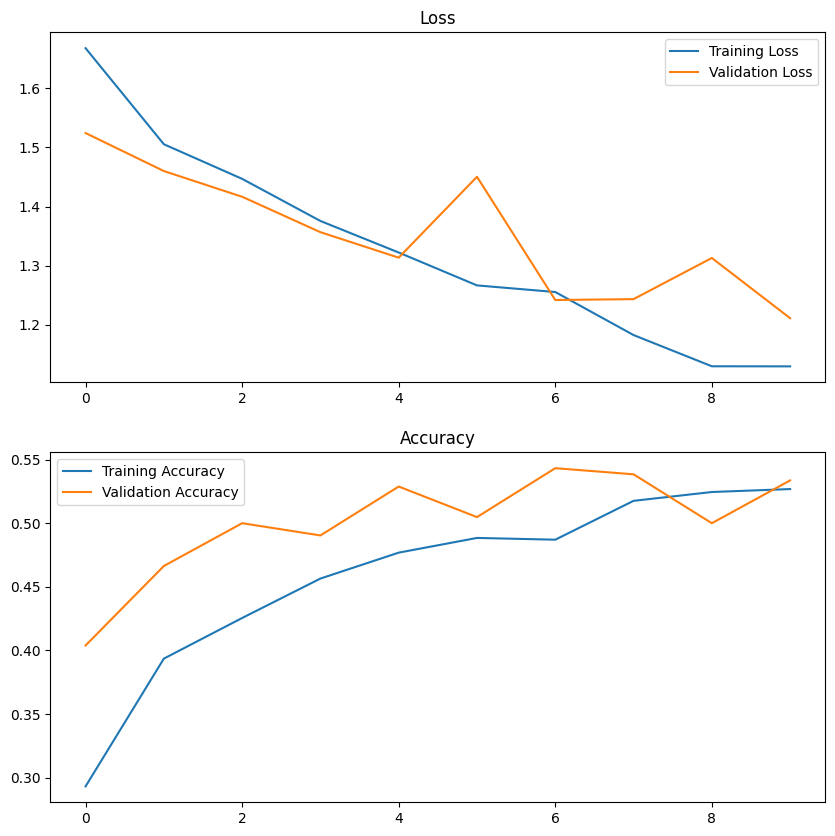

In [96]:
import matplotlib.pyplot as plt
import numpy as np

# plot validation results
fig, ax = plt.subplots(2, 1, figsize=(10,10))
ax[0].set_title('Loss')
ax[0].plot(history.epoch, history.history["loss"], label="Training Loss")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation Loss")
ax[1].set_title('Accuracy')
ax[1].plot(history.epoch, history.history["accuracy"], label="Training Accuracy")
ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation Accuracy")
#ax[0].set_xlim(1, 11)
#ax[1].set_xticklabels(np.arange(1, num_epochs+1))
ax[0].legend()
ax[1].legend()
plt.show()

In [97]:
import pandas as pd
history_df = pd.DataFrame(history.epoch)

In [98]:
# get best epoch performance for validation accuracy
max(history.history['val_accuracy'])

0.5432692170143127

**Overall:** Comparing both the models, the one without dropout layer was overfitting and at 15 epochs almost reached an accuracy of 100% at training set but on validation set it didn't cross 62%. However in our second model, with the dropout and reduced no. of epochs we could achieve the generalisation that we wanted. However te performance is not as expected.

### Let's make prediction with our second model and check the performance


In [99]:
# import required packages
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import pandas as pd
import numpy as np
from os import listdir


In [100]:
# parameters for prediction
model_filename = 'contents/models/imgclf_cnn_v02.h5'
img_width = 128
img_height = 128
labels_list = ['buildings','forest','glacier','mountain','sea','street']


# load model
model = load_model(model_filename)


In [101]:
# image pre-processing function
def preprocess_image(filepath):
    image = load_img(filepath, target_size=(img_width, img_height))
    image = img_to_array(image)
    image = np.expand_dims(image, axis = 0)
    image = image * (1./255)

    return image


# image prediction function
def make_prediction(image):
    class_probs = model.predict(image)
    pred_class = np.argmax(class_probs)
    predicted_label = labels_list[pred_class]
    predicted_prob = class_probs[0][pred_class]

    return predicted_label, predicted_prob

In [ ]:
import io
import os
import PIL.Image

# loop through test data
source_dir = '/content/Prediction Data/seg_pred/seg_pred'
folder_names = ['buildings','forest','glacier','mountain','sea','street']
actual_labels =[]
predicted_labels = []
predicted_probabilities = []
filenames = []

for folder in folder_names:

    images = os.listdir(os.path.join(source_dir, folder))

    for image in images:
        image_path = os.path.join(os.path.join(source_dir, folder),image)
        print(image_path)
        if image_path.endswith('.DS_Store'):
          continue
        if os.path.isfile(image_path):
          processed_image = preprocess_image(image_path)
          predicted_label, predicted_probability = make_prediction(processed_image)
          actual_labels.append(folder)
          predicted_labels.append(predicted_label)
          predicted_probabilities.append(predicted_probability)
          filenames.append(image)

        else:
          print('specified path is a folder')

In [103]:
# create dataframe to analyse
predictions_model_1_df = pd.DataFrame({"actual_label" : actual_labels,
                               "predicted_label" : predicted_labels,
                               "predicted_probability" : predicted_probabilities,
                               "filename" : filenames})
predictions_model_1_df["correct_prediction"] = np.where(predictions_model_1_df["predicted_label"] == predictions_model_1_df["actual_label"],1,0)


In [104]:
# overall test set accuracy
test_set_accuracy = predictions_model_1_df['correct_prediction'].sum() / len(predictions_model_1_df)
print(f'Accuracy: {test_set_accuracy}')

Accuracy: 0.5545851528384279


In [105]:
# confusion matrix(raw numbers)
confusion_matrix = pd.crosstab(predictions_model_1_df["predicted_label"], predictions_model_1_df["actual_label"])
print(confusion_matrix)

actual_label     buildings  forest  glacier  mountain  sea  street
predicted_label                                                   
buildings               30       0        5         1    5      11
forest                   2      35        0         0    0       0
glacier                  0       1        2         2    2       0
mountain                 1       0       29        32   29       2
sea                      2       0        1         2    3       0
street                   3       2        1         1    0      25


Sequential model achieved an accuracy of 55% on our prediction dataset. Let's try **_transfer learning_** approach using pre-trained _VGG16_ network.

# Transfer Learning using VGG16 ImageNet

Set Up flow For Training & Validation data

> VGG16 was trained on imageNet images of dimensions 224*224 pixels

In [106]:
training_data_dir = '/content/IntelImageClassification_Dataset/seg_train/seg_train'
validation_data_dir = '/content/IntelImageClassification_Dataset/seg_test/seg_test'
batch_size = 32
img_width = 224
img_height = 224
num_channels = 3
num_classes = 6

In [107]:
training_generator = ImageDataGenerator(preprocessing_function = preprocess_input,
                                        rotation_range = 20,
                                        width_shift_range = 0.2,
                                        height_shift_range = 0.2,
                                        zoom_range = 0.1,
                                        horizontal_flip = True,
                                        brightness_range=(0.5,1.5),
                                        fill_mode = 'nearest')

validation_generator = ImageDataGenerator(preprocessing_function = preprocess_input)

In [108]:
training_data = training_generator.flow_from_directory(directory = training_data_dir,
                                                      target_size = (img_width, img_height),
                                                      batch_size = batch_size,
                                                      class_mode = 'categorical')
validation_data = validation_generator.flow_from_directory(directory = validation_data_dir,
                                                      target_size = (img_width, img_height),
                                                      batch_size = batch_size,
                                                      class_mode = 'categorical')

Found 2160 images belonging to 6 classes.
Found 208 images belonging to 6 classes.


#Building our Network Architecture

We'll use our VGG16 model and as we only want initial layers of the VGG16 and not the dense layer or the output layer
we'll set include_top attribute to False
and we'll also freeze the network parameters for the entire network that we'll download, so that during training process they are not updated  and only updated parameters are those in our dense and output layer,
durig backpropagation.

This freezing will ensure we can use all the amazing features that this huge network of VGG16 has learnt from the ImageNet dataset of over 1000 classes

In [109]:
vgg = VGG16(input_shape = (img_width, img_height, num_channels), include_top = False)

#freeze all layers as we don't want to disturb the existing weights of the model but add on layers to fine tune the model
for layer in vgg.layers:
    layer.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [110]:
vgg.summary()
#Before freezing the layers vgg.summary displayed Trainable params: 14,714,688 and
#after freezing--> Trainable params: 0


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [111]:
flatten = Flatten()(vgg.output)

dense1 = Dense(128, activation= 'relu')(flatten)
dense2 = Dense(128, activation= 'relu')(dense1)

output = Dense(num_classes, activation = 'softmax')(dense2)

model = Model(inputs = vgg.inputs, outputs = output )

# compile network

model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

# view network architecture
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

#Train our Network

In [112]:
# training parameters
num_epochs = 10
model_filename = 'contents/imgclf_cnn_vgg.h5'


# callbacks
save_best_model = ModelCheckpoint(filepath = model_filename,
                                  monitor = 'val_accuracy',
                                  mode = 'max',
                                  verbose = 1,
                                  save_best_only= True)

# train the network

history = model.fit(x = training_data,
                    validation_data= validation_data,
                    batch_size = batch_size,
                    epochs = num_epochs,
                    callbacks = [save_best_model])


Epoch 1/10
68/68 [==============================] - ETA: 0s - loss: 2.3732 - accuracy: 0.7389
Epoch 1: val_accuracy improved from -inf to 0.85096, saving model to contents/imgclf_cnn_vgg.h5
68/68 [==============================] - 44s 548ms/step - loss: 2.3732 - accuracy: 0.7389 - val_loss: 1.5532 - val_accuracy: 0.8510
Epoch 2/10
68/68 [==============================] - ETA: 0s - loss: 1.1425 - accuracy: 0.8139
Epoch 2: val_accuracy improved from 0.85096 to 0.87500, saving model to contents/imgclf_cnn_vgg.h5
68/68 [==============================] - 37s 542ms/step - loss: 1.1425 - accuracy: 0.8139 - val_loss: 1.0237 - val_accuracy: 0.8750
Epoch 3/10
68/68 [==============================] - ETA: 0s - loss: 0.7963 - accuracy: 0.8370
Epoch 3: val_accuracy did not improve from 0.87500
68/68 [==============================] - 36s 535ms/step - loss: 0.7963 - accuracy: 0.8370 - val_loss: 0.9605 - val_accuracy: 0.8510
Epoch 4/10
68/68 [==============================] - ETA: 0s - loss: 0.6659 -

In [113]:
history_df = pd.DataFrame(history.history)
print(history_df)

       loss  accuracy  val_loss  val_accuracy
0  2.373184  0.738889  1.553170      0.850962
1  1.142478  0.813889  1.023652      0.875000
2  0.796295  0.837037  0.960535      0.850962
3  0.665865  0.849537  0.741664      0.884615
4  0.453667  0.871296  0.720251      0.846154
5  0.463860  0.875000  0.842873      0.875000
6  0.474909  0.881481  0.478048      0.899038
7  0.384683  0.880556  0.568006      0.913462
8  0.341406  0.895370  0.512869      0.879808
9  0.330693  0.901852  0.617709      0.875000


## Visualise Training & Validation Performance

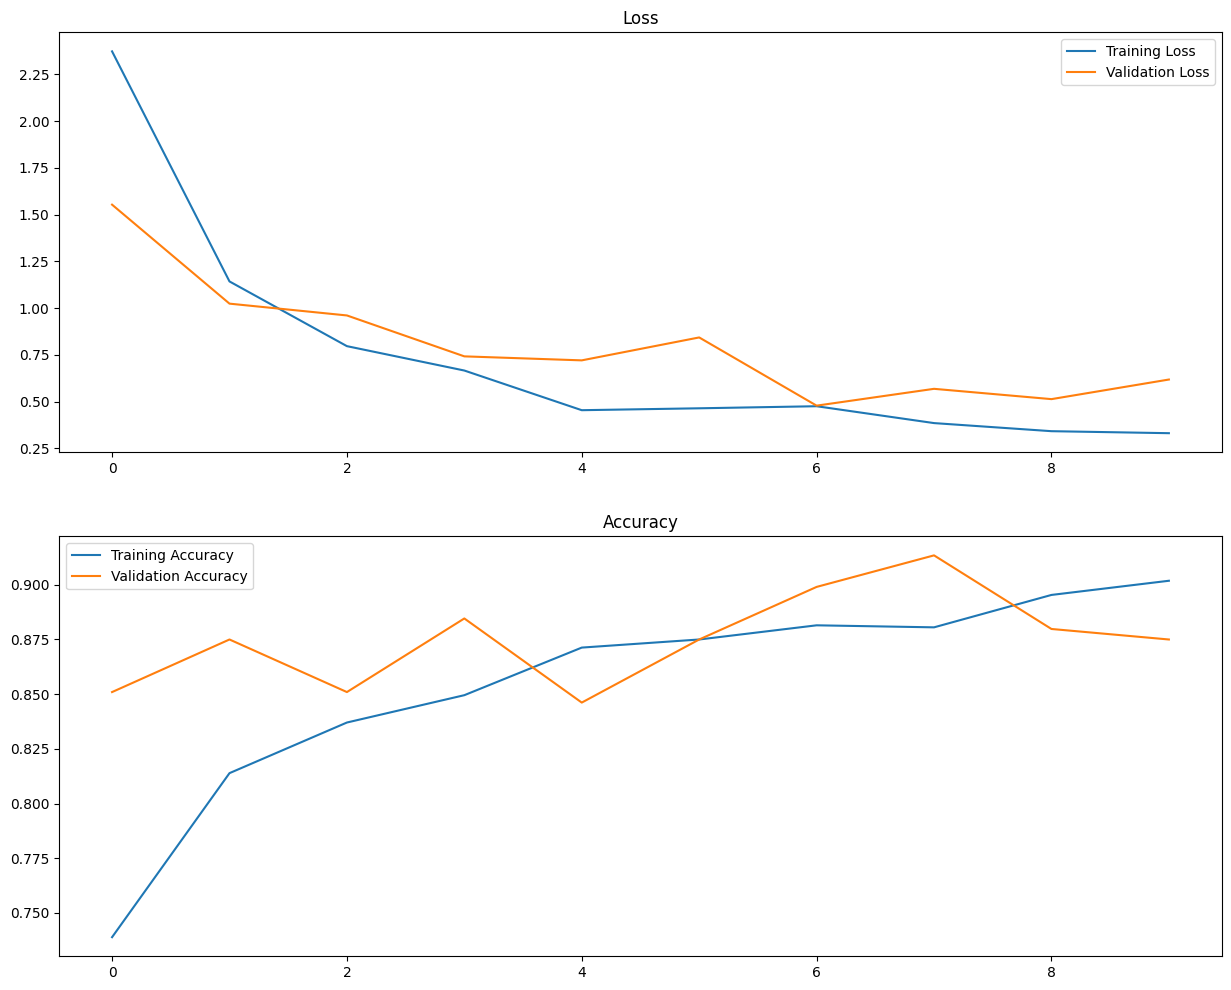

In [114]:
import matplotlib.pyplot as plt

# plot validation results
fig, ax = plt.subplots(2, 1, figsize=(15,12))
ax[0].set_title('Loss')
ax[0].plot(history.epoch, history.history["loss"], label="Training Loss")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation Loss")
ax[1].set_title('Accuracy')
ax[1].plot(history.epoch, history.history["accuracy"], label="Training Accuracy")
ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation Accuracy")
ax[0].legend()
ax[1].legend()
plt.show()


After training our model for 10 epochs it achieved an accuracy of 87% on our validation set and 90% on our training set. From the above plots we can see that our model is neither overfit nor underfit. Also we can see from the plot that validation accuracy reached to 90% around 7 epoch

In [115]:
# get best epoch performance for validation accuracy
max(history.history['val_accuracy'])

0.9134615659713745

## Make Predictions On New Data (Prediction Data Set)

In [116]:
# import required packages
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import pandas as pd
import numpy as np
from os import listdir


In [117]:
# parameters for prediction
model_filename = 'contents/imgclf_cnn_vgg.h5'
img_width = 224
img_height = 224
labels_list = ['buildings','forest','glacier','mountain','sea','street']

In [118]:
# load model
model = load_model(model_filename)


Defining functions for Image Pre-processing and image prediction

In [119]:
# image pre-processing function
def preprocess_image(filepath):
    image = load_img(filepath, target_size=(img_width, img_height))
    image = img_to_array(image)
    image = np.expand_dims(image, axis = 0)
    image = preprocess_input(image)

    return image


# image prediction function
def make_prediction(image):
    class_probs = model.predict(image)
    pred_class = np.argmax(class_probs)
    predicted_label = labels_list[pred_class]
    predicted_prob = class_probs[0][pred_class]

    return predicted_label, predicted_prob


In [120]:
!unzip /content/sample_data/IntelImageClassification_test.zip

unzip:  cannot find or open /content/sample_data/IntelImageClassification_test.zip, /content/sample_data/IntelImageClassification_test.zip.zip or /content/sample_data/IntelImageClassification_test.zip.ZIP.


In [ ]:
import io
import os
import PIL.Image

# loop through test data
source_dir = '/content/Prediction Data/seg_pred/seg_pred'
folder_names = ['buildings','forest','glacier','mountain','sea','street']
actual_labels =[]
predicted_labels = []
predicted_probabilities = []
filenames = []

for folder in folder_names:

    images = os.listdir(os.path.join(source_dir, folder))

    for image in images:
        image_path = os.path.join(os.path.join(source_dir, folder),image)
        print(image_path)
        if image_path.endswith('.DS_Store'):
          continue
        if os.path.isfile(image_path):
          processed_image = preprocess_image(image_path)
          predicted_label, predicted_probability = make_prediction(processed_image)
          actual_labels.append(folder)
          predicted_labels.append(predicted_label)
          predicted_probabilities.append(predicted_probability)
          filenames.append(image)

        else:
          print('specified path is a folder')

In [122]:
#code to remove the files that are not images and caused problem while predicting
# ! rm /content/PredictionData/seg_pred/seg_pred/buildings/.DS_Store
# ! rm /content/PredictionData/seg_pred/seg_pred/forest/.DS_Store
# ! rm /content/PredictionData/seg_pred/seg_pred/glacier/.DS_Store
# ! rm /content/PredictionData/seg_pred/seg_pred/mountain/.DS_Store
# ! rm /content/PredictionData/seg_pred/seg_pred/sea/.DS_Store
# ! rm /content/PredictionData/seg_pred/seg_pred/street/.DS_Store

In [123]:
# create dataframe to analyse
predictions_df = pd.DataFrame({"actual_label" : actual_labels,
                               "predicted_label" : predicted_labels,
                               "predicted_probability" : predicted_probabilities,
                               "filename" : filenames})
predictions_df["correct_prediction"] = np.where(predictions_df["predicted_label"] == predictions_df["actual_label"],1,0)



In [124]:
# overall test set accuracy
test_set_accuracy = predictions_df['correct_prediction'].sum() / len(predictions_df)
print(f'Accuracy: {test_set_accuracy}')


Accuracy: 0.8733624454148472


In [125]:
# confusion matrix(raw numbers)
confusion_matrix = pd.crosstab(predictions_df["predicted_label"], predictions_df["actual_label"])
print(confusion_matrix)

actual_label     buildings  forest  glacier  mountain  sea  street
predicted_label                                                   
buildings               35       0        0         0    0       7
forest                   0      38        0         0    0       0
glacier                  0       0       25         3    1       0
mountain                 0       0       10        34    0       0
sea                      0       0        3         1   38       1
street                   3       0        0         0    0      30


In [126]:
# confusion matrix(percentage)
confusion_matrix = pd.crosstab(predictions_df["predicted_label"], predictions_df["actual_label"], normalize= 'columns')
print(confusion_matrix)

actual_label     buildings  forest   glacier  mountain       sea    street
predicted_label                                                           
buildings         0.921053     0.0  0.000000  0.000000  0.000000  0.184211
forest            0.000000     1.0  0.000000  0.000000  0.000000  0.000000
glacier           0.000000     0.0  0.657895  0.078947  0.025641  0.000000
mountain          0.000000     0.0  0.263158  0.894737  0.000000  0.000000
sea               0.000000     0.0  0.078947  0.026316  0.974359  0.026316
street            0.078947     0.0  0.000000  0.000000  0.000000  0.789474


Model achieved an accuracy of 91% on validation data and 87% on prediction dataset, concluding that using transfer learning approach and VGG16 resulted in extremely good performance metric compared to our sequential model. However, it has trouble with glacier and mountain. Well, it can be understandable as as there are glaciers(& confusing them with sea) look like mountain and surrounded by sea. It had slight trouble with building & street.But, it can detects forest, buildings and sea with high accuracy!

#Checking the mislabeled images

This will give us a clear idea as to why the model misclassified them.

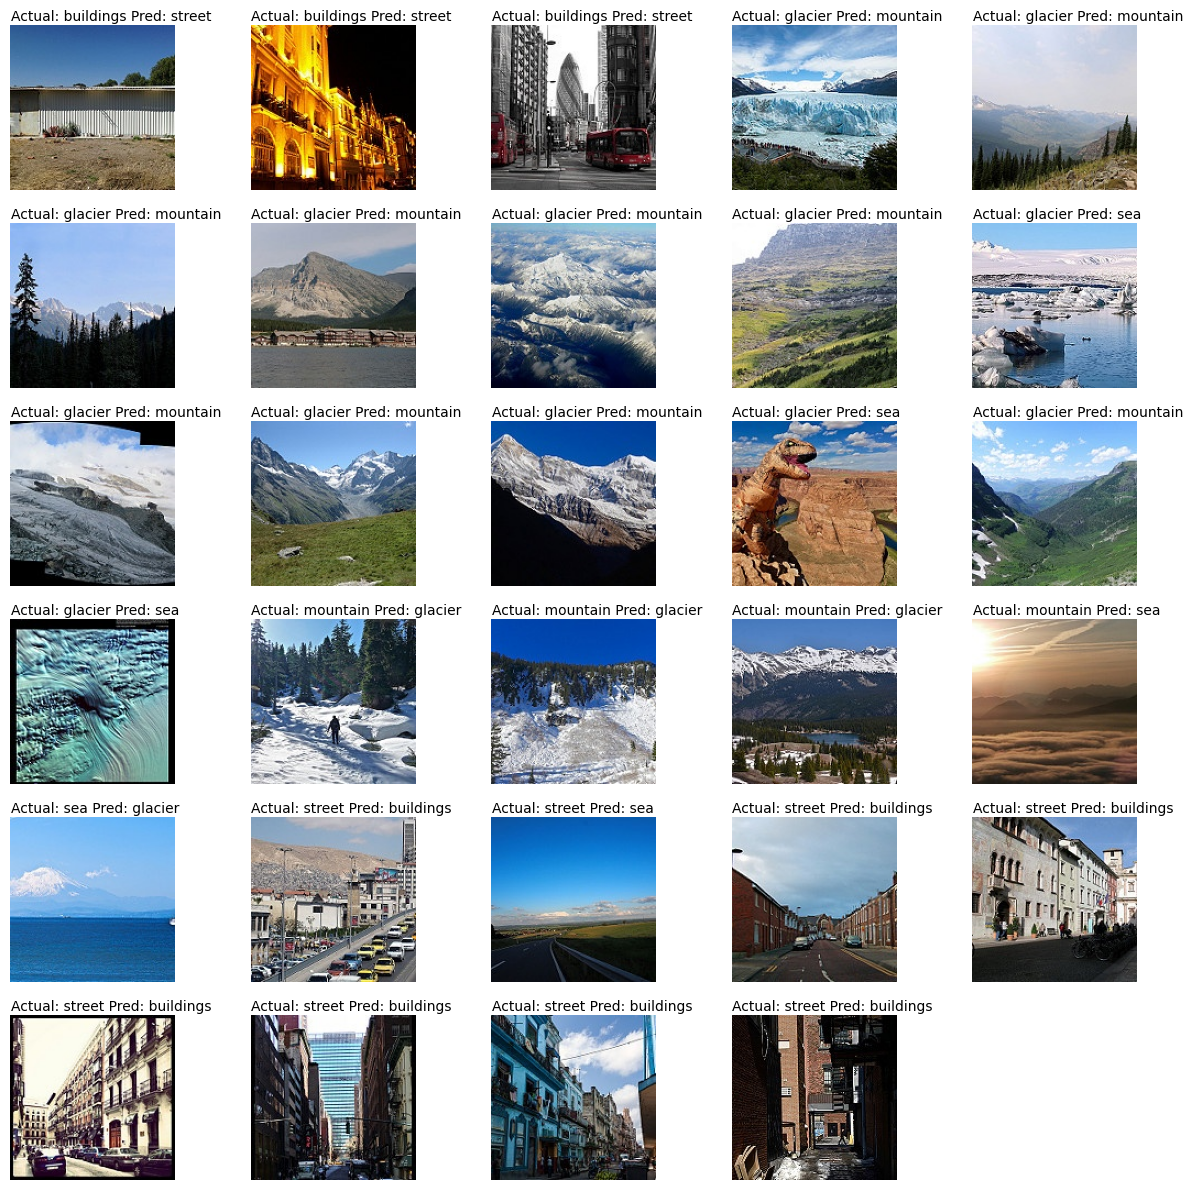

In [127]:
from IPython.core.display import display_jpeg
import numpy as np

mislabeled_indices = np.where(predictions_df["predicted_label"] != predictions_df["actual_label"])
image =[]
actual_label =[]
predicted_label =[]

for idx in mislabeled_indices[0]:
  folder = "".join(predictions_df["actual_label"].iloc[idx])
  filename = "".join(predictions_df["filename"].iloc[idx])

  image.append(PIL.Image.open(source_dir +'/' + folder + '/' + filename))
  predicted_label.append(predictions_df["predicted_label"].iloc[idx])
  actual_label.append(predictions_df["actual_label"].iloc[idx])
  #image.show()
  #print("Actual_label:"+ actual_label, "Predicted_label :" + predicted_label)

plt.figure(figsize=(15,15)) # specifying the overall grid size

for i in range(len(image)):
    plt.subplot(6,5,i+1)    # As we have 27 missclassified images we set up the grid of 6*5 (30)
    plt.imshow(image[i])
    plt.axis('off')
    plt.text(0, -5, ("Actual: "+actual_label[i]+" Pred: " + predicted_label[i]))

plt.show()
